# Homework 05: Neural Networks

## Submission Instructions:
1. Once the notebook is completed, **RESTART THE KERNEL AND RUN ALL CELLS**, save it and submit it. 
2. DO NOT submit the data from the assignment.
3. Whenever we ask to .head(10) the results or print out a value, please use `print()` so for example `print(df.head(10))`. Print only the answers to the questions that have been asked.  Do not print the head of a dataset unless explicitly asked. 
4. Whenever displaying a graph use `plt.show()`
5. For theoretical answers/short answers, use print() (e.g., print("your answer")).
6. Wherever we have code displayed to print out values, use that code as a template to print out your output.  For example, if we give you `print(f'Threshold for best accuracy: {}')` please use code in this style to print out your output.

**Question 1:**  
Import all necessary libraries for this assignment.  
*No code to write here, but review the imports to understand what tools you'll be using (e.g., PyTorch, scikit-learn, NLTK, etc.).*

In [212]:
import json
import re
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
from itertools import chain

**Question 2:**  
Load the dataset for this assignment.  
- Load in all_jobs.json into a data frame
- Only select your jobs using job_assignments_sampled.json (Simon, your jobs should be included by now)
- .head() the data frame

In [213]:
all_jobs=pd.read_json("all_jobs.json")
sampled_assignments=pd.read_json("job_assignments_sampled.json")
my_jobs=sampled_assignments["mudzimtb@clarkson.edu"][2]
my_jobs_id=[job.replace('.json', '') for job in my_jobs]
jobs= all_jobs[all_jobs['jid'].isin(my_jobs_id)].copy()
jobs.head()

C:\Users\mdzimtb\AppData\Local\Temp\ipykernel_640\2841750588.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  my_jobs=sampled_assignments["mudzimtb@clarkson.edu"][2]


,jid,company_name,company_industries,company_size,company_hq_location,company_year_founded,company_website,company_description,company_followers,company_why_work_here_blurb,...,job_location,job_description,job_posted_time,job_salary,job_employment_type,job_benefits,job_is_remote,job_industry,job_category_title,search
2,001045e90d901843,City of Fishers,[Public Administration],201 - 500 Employees,"Fishers, IN, US",1872,fishers.in.us,,14,,...,"Fishers, IN",<div><strong>Title: Business Analyst<br>Salary...,"July 07, 2025","$65,463 to $79,902 Yearly",Full-Time,None,False,Business,Business Analyst,[Business Analyst]
3,0012b8f4bdf93d97,,,,,,,,14,,...,"Nashville, TN",<p>Are you passionate about building large sca...,"July 08, 2025","$119,300 to $149,700 Yearly",Other,"[Medical, Life Insurance, Retirement]",False,Technology,Senior Principal Software Developer,[Mlops Engineer]
4,0018a96cd42d3175,,,,,,,,14,,...,"Brighton, CO","<div><strong>Salary :</strong> $84,952.10 - $1...","August 21, 2025","$84,952 to $123,181 Yearly",Full-Time,"[Vision, Medical, Dental, Paid Time Off, Life ...",False,Business,Senior Business Analyst,[Business Analyst]
5,001b8c4e8912a539,Alpha Omega Integration,[Software Development],201 - 500 Employees,"Vienna, VA, US",2010,alphaomegaintegration.com,,14,,...,"Vienna, VA",<div><strong>Job Title: Business Analyst</stro...,"July 22, 2025","$74,065 to $140,000 Yearly",Full-Time,"[Medical, Dental, Paid Time Off, Life Insuranc...",False,Business,Business Analyst,[Business Analyst]
10,004164e63dae5d36,,,,,,,,14,,...,"Madison, WI",<div> <div> <p></p> Company Description ...,"June 24, 2025","$144,100 to $159,700 Yearly",Full-Time,"[Vision, Medical, Dental, Paid Time Off, Life ...",False,Real Estate,AI Engineer - Machine Learning (onsite Madison...,[Nlp Engineer]


**Question 3:**  
Clean the dataset by removing rows with missing or multiple labels
- Filter out rows where the 'search' field is missing and the number of labels is not equal to 1.
- Create a new column called 'label' with the cleaned label.

In [214]:
filtered_jobs = jobs[jobs['search'].apply(lambda x: isinstance(x, list) and len(x) == 1)]
filtered_jobs.loc[:, 'label'] = filtered_jobs['search'].str[0]

C:\Users\mdzimtb\AppData\Local\Temp\ipykernel_640\2959139304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_jobs.loc[:, 'label'] = filtered_jobs['search'].str[0]


**Question 4:**  
Extract the job descriptions and labels into separate lists for further processing.
- Assign the job descriptions to `texts` and the labels to `labels`.

In [215]:
texts=list(filtered_jobs["job_description"])
labels=list(filtered_jobs["label"])

**Question 5:**  
Encode the labels as integers using `LabelEncoder`.
- Fit the encoder to your labels and transform them.
- **Hint:** Print the encoded labels to verify the transformation.

In [216]:
labels_intgr = LabelEncoder()
encoded_labels = labels_intgr.fit_transform(labels)
print(encoded_labels)

[1 8 1 ... 5 2 2]


**Question 6:**  
Define a custom text standardization function.
- Remove HTML, lowercase, remove punctuation, and filter out stopwords.
- Use NLTK's stopwords and BeautifulSoup for text cleaning.

In [217]:

STOP_WORDS = set(stopwords.words("english"))
PUNCT_RE = re.compile(r"[^a-z\s]")  

def clean_text(html_text):
    if not html_text:
        return []
    text = BeautifulSoup(html_text, "html.parser").get_text(separator=" ")
    text = text.lower()
    text = PUNCT_RE.sub(" ", text)
    words = text.split()
    return [w for w in words if w not in STOP_WORDS and len(w) > 1]


**Question 7:**  
Apply your custom standardization function to all job descriptions.
- Store the cleaned texts in `X_cleaned`.

In [218]:
X_cleaned = [clean_text(item) for item in texts]

**Question 8:**  
Split your data into training, validation, and test sets.
- Use stratified splits to maintain label balance.
- Convert the labels to PyTorch tensors for later use.
- Print out the shapes of your splits.

In [219]:
documents = [" ".join(doc) for doc in X_cleaned]

X = np.array(documents)
y = np.array(encoded_labels)

X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

In [220]:
print(f"X_train for documents: {X_train.shape}")
print(f"X_test for documents:  {X_test.shape}")
print(f"X_val for documents:   {X_val.shape}")


print(f"y_train for tensor: {y_train_tensor.shape}")
print(f"y_test for tensor:  {y_test_tensor.shape}")
print(f"y_val for tensor:   {y_val_tensor.shape}")

X_train for documents: (1841,)
X_test for documents:  (395,)
X_val for documents:   (395,)
y_train for tensor: torch.Size([1841])
y_test for tensor:  torch.Size([395])
y_val for tensor:   torch.Size([395])


**Question 9:**  
Implement a function ***with the provided function signature*** to prepare TF-IDF features and return PyTorch DataLoaders.  It should
- Vectorize the text using TF-IDF.
- Convert the features to tensors and wrap them in DataLoaders.

In [221]:

def prep_tfidf(X_train,
               X_valid,
               X_test,
               y_train_tensor,
               y_valid_tensor,
               y_test_tensor,
               batch_size=32,
               max_features=10000,
               ngram_range=(1, 1)):

    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        lowercase=False,                 
        preprocessor=None,
        tokenizer=None,
        token_pattern=r"(?u)\b\w+\b"   
    )

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
    X_test_tfidf  = tfidf_vectorizer.transform(X_test)

    X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
    X_valid_tensor = torch.tensor(X_valid_tfidf.toarray(), dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_tfidf.toarray(),  dtype=torch.float32)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    valid_data = TensorDataset(X_valid_tensor, y_valid_tensor)
    test_data  = TensorDataset(X_test_tensor,  y_test_tensor)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)


    return tfidf_vectorizer, train_loader, valid_loader, test_loader


**Question 10:**  
Use your `prep_tfidf` function to prepare the data for modeling.
- Set `max_features` to 10000 and `ngram_range` to (1,2).
- Print the shapes of the first item in the train_loader

In [222]:

vectorizer, train_loader, val_loader, test_loader = prep_tfidf(X_train,
    X_val,
    X_test,
    y_train_tensor,
    y_val_tensor, 
    y_test_tensor,
    batch_size=32,
    max_features=10_000,
    ngram_range=(1, 2)
)

xb, yb = next(iter(train_loader))
print("First train batch X shape:", xb.shape) 
print("First train batch y shape:", yb.shape)



First train batch X shape: torch.Size([32, 10000])
First train batch y shape: torch.Size([32])


**Question 11:**  
Define a simple feedforward neural network for TF-IDF features.
- Implement a class ***using the provided class header and constructor signature*** with configurable hidden layers and dropout.  Should be:
    - An input Linear layer. Make sure the input dimension matches your TF-IDF feature size.
    - Multiple layers in the __init__ method in a list and then wrap the list in a nn.ModuleList object.  Then in the forward method, you can loop through those layers and input your x
    - An optional dropout layer
    - Since this is a multiclass problem I would recommend not using a last softmax layer as the loss function for multiclass problems in PyTorch expects unnormalized logits.
- Instantiate the model and print its structure.

In [223]:

class DenseTFIDFModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden_layers=0, dropout=0.0):
        super().__init__()

        self.use_hidden = n_hidden_layers > 0
        self.dropout = nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()

        if self.use_hidden:
            
            self.input_layer = nn.Linear(input_dim, hidden_dim)
            
            self.hidden_layers = nn.ModuleList(
                [nn.Linear(hidden_dim, hidden_dim) for _ in range(n_hidden_layers - 1)]
            )
            last_dim = hidden_dim
        else:
          
            self.input_layer = None
            self.hidden_layers = nn.ModuleList([])
            last_dim = input_dim

        self.output_layer = nn.Linear(last_dim, output_dim)

    def forward(self, x):
        if self.input_layer is not None:
            x = F.relu(self.input_layer(x))
            x = self.dropout(x)

        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)

        return self.output_layer(x)  


In [224]:
input_dim  = len(vectorizer.vocabulary_)
output_dim = len(labels_intgr.classes_)  

model = DenseTFIDFModel(
    input_dim=input_dim,
    hidden_dim=256,
    output_dim=output_dim,
    n_hidden_layers=2,  
    dropout=0.3
)
print(model)


DenseTFIDFModel(
  (dropout): Dropout(p=0.3, inplace=False)
  (input_layer): Linear(in_features=10000, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)


**Question 12:**  
Calculate and print the total and trainable parameters in your model.
- Print the number of parameters for each layer.

In [225]:
from collections import defaultdict 
total_params = 0
trainable_params = 0

per_layer = defaultdict(lambda: {"total": 0, "trainable": 0})

for name, p in model.named_parameters():
    n = p.numel() 
    total_params += n
    if p.requires_grad:
        trainable_params += n

    parts = name.split(".")
    layer_key = f"{parts[0]}.{parts[1]}" if parts[0] == "hidden_layers" and len(parts) > 1 else parts[0]
    per_layer[layer_key]["total"]     += n
    per_layer[layer_key]["trainable"] += n if p.requires_grad else 0

print("Parameters Per Layer")
for layer in sorted(per_layer.keys()):
    t  = per_layer[layer]["total"]
    tr = per_layer[layer]["trainable"]
    print(f"{layer:<18}: total={t:,}  trainable={tr:,}")

print(f"\nTotal Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")


Parameters Per Layer
hidden_layers.0   : total=65,792  trainable=65,792
input_layer       : total=2,560,256  trainable=2,560,256
output_layer      : total=2,570  trainable=2,570

Total Parameters:     2,628,618
Trainable Parameters: 2,628,618


**Question 13:**  
Implement a training loop for your model in a function ***using the provided function signature and return dictionary***.
- 
- Train the model for 20 epochs.
- Track and print training/validation loss, accuracy, and F1 score for each epoch.
- Hints:
    - The criterion (loss function) will be the cross entropy loss.  This expects 2 arguments; the unnormalized logits and the y labels
    - I would keep track of my predicted ys for each batch.  At then end of training for 1 epoch you can just use metrics.accuracy_score or metrics.f1_score
    - I returned my results in a dictionary like 
    
```python 
{'epochs': range(epochs),
 'training_losses': losses,
 'training_accuracies': accuracies,
 'training_f1_scores': f1_scores,
 'val_losses': val_losses,
 'val_accuracies': val_accuracies,
 'val_f1_scores': val_f1_scores,
 'final_model': model}
```

In [226]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, valid_loader, epochs=20, device=None):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()     
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

    losses, accs, f1s = [], [], []
    val_losses, val_accs, val_f1s = [], [], []

    for _ in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)                  
            y_batch = y_batch.to(device).long()           

            optimizer.zero_grad()
            logits = model(X_batch)                    
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)
            all_preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy())
            all_labels.extend(y_batch.detach().cpu().numpy())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc  = accuracy_score(all_labels, all_preds)
        epoch_train_f1   = f1_score(all_labels, all_preds, average='macro')

        model.eval()
        val_running_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).long()

                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_running_loss += loss.item() * X_batch.size(0)
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(y_batch.cpu().numpy())

        epoch_val_loss = val_running_loss / len(valid_loader.dataset)
        epoch_val_acc  = accuracy_score(val_labels, val_preds)
        epoch_val_f1   = f1_score(val_labels, val_preds, average='macro')

        losses.append(epoch_train_loss); accs.append(epoch_train_acc); f1s.append(epoch_train_f1)
        val_losses.append(epoch_val_loss); val_accs.append(epoch_val_acc); val_f1s.append(epoch_val_f1)

        print(f"Train loss {epoch_train_loss:.4f}, Acc {epoch_train_acc:.4f}, F1 {epoch_train_f1:.4f} | "
              f"Val loss {epoch_val_loss:.4f}, Acc {epoch_val_acc:.4f}, F1 {epoch_val_f1:.4f}")

    return {
        'epochs': range(1, epochs+1),
        'training_losses': losses, 'training_accuracies': accs, 'training_f1_scores': f1s,
        'val_losses': val_losses, 'val_accuracies': val_accs, 'val_f1_scores': val_f1s,
        'final_model': model
    }


**Question 14:**  
- Plot the training and validation loss curves.
- I would put this in a function

Train loss 1.7311, Acc 0.3829, F1 0.3457 | Val loss 1.0521, Acc 0.6456, F1 0.5592
Train loss 0.7032, Acc 0.7496, F1 0.6881 | Val loss 0.9432, Acc 0.6810, F1 0.6356
Train loss 0.2859, Acc 0.9136, F1 0.8951 | Val loss 1.0219, Acc 0.6987, F1 0.6515
Train loss 0.0921, Acc 0.9788, F1 0.9753 | Val loss 1.0546, Acc 0.7316, F1 0.7015
Train loss 0.0708, Acc 0.9826, F1 0.9800 | Val loss 1.1960, Acc 0.7215, F1 0.6828
Train loss 0.0469, Acc 0.9913, F1 0.9903 | Val loss 1.3019, Acc 0.7063, F1 0.6654
Train loss 0.0431, Acc 0.9935, F1 0.9934 | Val loss 1.1779, Acc 0.7266, F1 0.6964
Train loss 0.0247, Acc 0.9935, F1 0.9925 | Val loss 1.2438, Acc 0.7114, F1 0.6774
Train loss 0.0277, Acc 0.9967, F1 0.9962 | Val loss 1.2922, Acc 0.7266, F1 0.6913
Train loss 0.0154, Acc 0.9973, F1 0.9969 | Val loss 1.3303, Acc 0.7266, F1 0.6945
Train loss 0.0240, Acc 0.9962, F1 0.9957 | Val loss 1.3356, Acc 0.7165, F1 0.6766
Train loss 0.0174, Acc 0.9951, F1 0.9943 | Val loss 1.4692, Acc 0.7316, F1 0.7005
Train loss 0.026

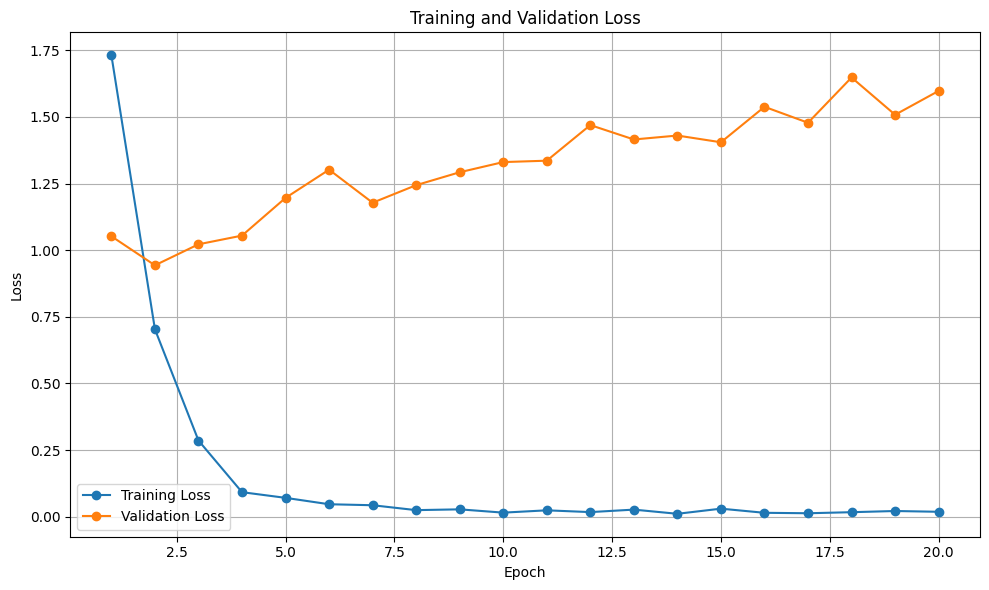

In [227]:
def plot_loss_curves(results):
    epochs = results['epochs']
    train_losses = results['training_losses']
    val_losses = results['val_losses']

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results = train_model(model, train_loader, val_loader)
plot_loss_curves(results)

**Question 15:**  
Evaluate your trained model on the test set.
- Print a classification report and plot the confusion matrix.
- I would put this code in a function and return the y_pred and y_true

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.16      0.25        32
           1       0.89      0.87      0.88        46
           2       0.77      0.84      0.80        43
           3       0.71      0.79      0.75        47
           4       0.72      0.69      0.70        45
           5       0.73      0.71      0.72        45
           6       0.70      0.83      0.76        46
           7       0.49      0.64      0.55        33
           8       0.46      0.38      0.42        29
           9       0.34      0.41      0.38        29

    accuracy                           0.67       395
   macro avg       0.64      0.63      0.62       395
weighted avg       0.67      0.67      0.65       395



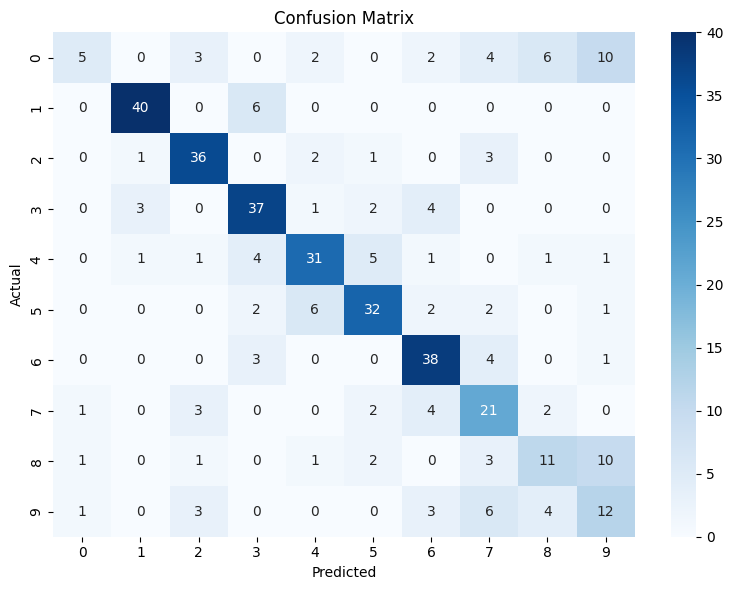

In [228]:

def evaluate_model(model, test_loader, device=torch.device('cpu')):
    model.eval()
    model.to(device)
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_loader)

report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


**Question 16:**  
We are now going to experiment with different model configurations.
- Try the values below for `max_features`, number of hidden layers, and dropout
```python
scenarios = [(10_000, 1, 0.0),
             (5_000, 1, 0.0),
             (500, 1, 0.0),
             (10_000, 2, 0.0),
             (10_000, 3, 0.0),
             (10_000, 3, 0.2)
             ]
```
- First, prepare the data for each scenario and store the DataLoaders in a dictionary where the keys are the max_features size.  This avoids having to prepare the DataLoaders more than once, since max_features is the only thing that is changed for the data prep.

In [229]:
scenarios = [(10_000, 1, 0.0),
             (5_000, 1, 0.0),
             (500, 1, 0.0),
             (10_000, 2, 0.0),
             (10_000, 3, 0.0),
             (10_000, 3, 0.2)
             ]

dataldr_maxftr = {}

for mf, _, _ in scenarios:
    if mf not in dataldr_maxftr:
        vec, tl, vl, te = prep_tfidf(
            X_train, X_val, X_test,
            y_train_tensor, y_val_tensor, y_test_tensor,
            max_features=mf,
            ngram_range=(1, 2),
        )
        dataldr_maxftr[mf] = {
            "vectorizer": vec,
            "train_loader": tl,
            "val_loader": vl,
            "test_loader": te,
            "input_dim": len(vec.vocabulary_)  
        }

**Question 17:**  
Train and evaluate your model for each scenario for 20 epochs.
- For each configuration, train the model and also evaluate its test F1 score.
- Store the results for later comparison.

In [230]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sums = []
for mf, n_hidden, dr in scenarios:
    pkg = dataldr_maxftr[mf]
    train_loader = pkg["train_loader"]
    val_loader   = pkg["val_loader"]
    test_loader  = pkg["test_loader"]
    input_dim    = pkg["input_dim"]
    output_dim   = len(labels_intgr.classes_)

    model = DenseTFIDFModel(
        input_dim=input_dim, hidden_dim=256, output_dim=output_dim,
        n_hidden_layers=n_hidden, dropout=dr
    )

    hist = train_model(model, train_loader, val_loader, epochs=20, device=device)

    y_true, y_pred = evaluate_model(hist['final_model'], test_loader, device=device)
    test_f1 = f1_score(y_true, y_pred, average='macro')

    sums.append({
        'max_features': mf,
        'n_hidden_layers': n_hidden,
        'dropout': dr,
        'best_val_f1': max(hist['val_f1_scores']),
        'test_f1': test_f1
    })

results_df = pd.DataFrame(sums).sort_values('test_f1', ascending=False, ignore_index=True)
print(results_df)


Train loss 1.6644, Acc 0.5122, F1 0.4479 | Val loss 1.0550, Acc 0.6835, F1 0.6082
Train loss 0.5317, Acc 0.8740, F1 0.8549 | Val loss 0.8630, Acc 0.7063, F1 0.6588
Train loss 0.1364, Acc 0.9794, F1 0.9757 | Val loss 0.8657, Acc 0.7266, F1 0.6947
Train loss 0.0467, Acc 0.9924, F1 0.9912 | Val loss 0.8600, Acc 0.7316, F1 0.6939
Train loss 0.0277, Acc 0.9951, F1 0.9943 | Val loss 0.9251, Acc 0.7367, F1 0.6897
Train loss 0.0276, Acc 0.9940, F1 0.9932 | Val loss 0.8976, Acc 0.7342, F1 0.6965
Train loss 0.0204, Acc 0.9962, F1 0.9957 | Val loss 0.8995, Acc 0.7165, F1 0.6858
Train loss 0.0276, Acc 0.9957, F1 0.9950 | Val loss 0.9426, Acc 0.7367, F1 0.6942
Train loss 0.0232, Acc 0.9951, F1 0.9945 | Val loss 0.9590, Acc 0.7266, F1 0.6881
Train loss 0.0188, Acc 0.9951, F1 0.9945 | Val loss 0.9532, Acc 0.7215, F1 0.6771
Train loss 0.0187, Acc 0.9957, F1 0.9947 | Val loss 0.9892, Acc 0.7392, F1 0.6924
Train loss 0.0203, Acc 0.9962, F1 0.9954 | Val loss 0.9464, Acc 0.7342, F1 0.6946
Train loss 0.013

**Question 18:**  
Use the custom PyTorch `Dataset` for word ID sequences.  The code is given for you.  Nothing to do

In [231]:
class TextDataset(Dataset):
    def __init__(self, X, y, max_len=100):
        self.X = X
        self.y = y
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx][:self.max_len]
        # Pad the text with 0s
        x = x + [0]*(self.max_len - len(x))
        return torch.tensor(x, dtype=torch.long), self.y[idx]

**Question 19:**  
Create a function to prepare word ID features for embedding models.  Basically put what we created in class into a function
- Build a vocabulary from the training data.
- Convert texts to sequences of word IDs.
- Return DataLoaders and the word-to-index mapping.

In [232]:
counter = Counter()
def prep_word_id_features(X_train, y_train_tensor,X_val,y_val_tensor,X_test,y_test_tensor,max_len=100, min_freq=1, max_vocab=None, batch_size=32):
    for toks in X_train:
        counter.update(toks)

    words = [w for w, c in counter.items() if c >= min_freq]

    if max_vocab is not None:
        most_common = counter.most_common(max_vocab - 2)  
        words = [w for w, _ in most_common if counter[w] >= min_freq]

    word2idx = {"<PAD>": 0, "<UNK>": 1}
    for w in words:
        if w not in word2idx:
            word2idx[w] = len(word2idx)

    def to_ids_list(list_of_token_lists):
        seqs = []
        for toks in list_of_token_lists:
            ids = [word2idx.get(t, 1) for t in toks[:max_len]]
            if len(ids) < max_len:
                ids = ids + [0] * (max_len - len(ids))    
            seqs.append(ids)
        return np.array(seqs, dtype=np.int64)

    X_train_ids = to_ids_list(X_train)
    X_val_ids   = to_ids_list(X_val)
    X_test_ids  = to_ids_list(X_test)

    train_ds = TensorDataset(torch.tensor(X_train_ids, dtype=torch.long), y_train_tensor)
    val_ds   = TensorDataset(torch.tensor(X_val_ids,   dtype=torch.long), y_val_tensor)
    test_ds  = TensorDataset(torch.tensor(X_test_ids,  dtype=torch.long), y_test_tensor)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size)

    return train_loader, valid_loader, test_loader, word2idx


train_loader, valid_loader, test_loader, word2idx = prep_word_id_features(X_train,y_train_tensor,X_val,y_val_tensor,X_test,y_test_tensor,max_len=100, min_freq=1, max_vocab=300, batch_size=32)

**Question 20:**  
Define a feedforward neural network with an embedding layer ***using the provided class header and constructor signature***.
- Use average pooling over word embeddings.
- Add configurable hidden layers and dropout like we did for the TFIDF model.
- Instantiate the model and print its structure.

In [ ]:
class EmbeddingFFN(nn.Module):
    def __init__(self,vocab_size,embed_dim,hidden_dim,output_dim,n_hidden_layers=0,dropout=0.0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.hidden_layers = nn.ModuleList()
        in_dim = embed_dim
        for _ in range(n_hidden_layers):
            self.hidden_layers.append(nn.Linear(in_dim, hidden_dim))
            in_dim = hidden_dim

        self.output = nn.Linear(in_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout) if dropout and dropout > 0 else None

    def forward(self, x):
        emb = self.embed(x)                         
        mask = (x != 0).unsqueeze(-1).float()           
        summed = (emb * mask).sum(dim=1)                
        lengths = mask.sum(dim=1).clamp(min=1.0)        
        avg = summed / lengths                   
        h = avg
        for layer in self.hidden_layers:
            h = layer(h)
            h = F.relu(h)
            if self.dropout is not None:
                h = self.dropout(h)

        logits = self.output(h)                          
        return logits

model = EmbeddingFFN(vocab_size=len(word2idx),embed_dim=100,hidden_dim=256,output_dim=10,n_hidden_layers=2,dropout=0.3)
print(model)


EmbeddingFFN(
  (embed): Embedding(29, 100, padding_idx=0)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**Question 21:**  
Calculate and print the total and trainable parameters for your embedding model.
- Print the number of parameters for each layer.

In [234]:
total_params = 0
trainable_params = 0

for name, p in model.named_parameters():
    n = p.numel()
    total_params += n
    if p.requires_grad:
        trainable_params += n
    print(f"{name:<28}: {n:,} parameters")

print(f"\nTotal parameters    : {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


embed.weight                : 2,900 parameters
hidden_layers.0.weight      : 25,600 parameters
hidden_layers.0.bias        : 256 parameters
hidden_layers.1.weight      : 65,536 parameters
hidden_layers.1.bias        : 256 parameters
output.weight               : 2,560 parameters
output.bias                 : 10 parameters

Total parameters    : 97,118
Trainable parameters: 97,118


**Question 22:**  
Prepare data for several embedding model scenarios.
- Use the vocabulary sizes, embedding dimensions, hidden layers and dropout rates below.
```python
scenarios_emb = [(10_000, 16, 1, 0.0),
                 (300, 16, 1, 0.0),
                 (50, 32, 2, 0.2)]
```
- Store the DataLoaders and word2idx mappings for each scenario in a dictionary again where the vocab size is the key and the prepped data are the values

In [235]:
scenarios_emb = [(10_000, 16, 1, 0.0),
                 (300, 16, 1, 0.0),
                 (50, 32, 2, 0.2)]

prep_by_vocab = {}
for vocab_size, embed_dim, n_hidden, drop in scenarios_emb:
    train_loader, valid_loader, test_loader, word2idx = prep_word_id_features(
        X_train, y_train_tensor,X_val,y_val_tensor,X_test,y_test_tensor,
        max_len=100,min_freq=1,max_vocab=vocab_size,batch_size=32)
    prep_by_vocab[vocab_size] = {"train_loader": train_loader,
                                 "val_loader":valid_loader,
                                 "test_loader":test_loader,"word2idx":word2idx,
                                 "embed_dim":embed_dim,"n_hidden":n_hidden,"dropout":drop}

**Question 23:**  
Train and evaluate your embedding models for each scenario for ***50*** epochs.
- For each configuration, train the model and evaluate its test F1 score.
- Store the results for later comparison.

In [ ]:

def train_and_collect(model, train_loader, valid_loader, test_loader=None,epochs=50, lr=1e-3, n_classes=10):
    device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses, val_losses = [], []
    accuracies, val_accuracies = [], []
    f1s, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        train_true, train_pred = [], []

        for X_batch, y_batch in train_loader:
            xb = X_batch.to(device)
            yb = y_batch.to(device).long()

            optimizer.zero_grad()
            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)

            train_true.append(yb.detach().cpu())
            train_pred.append(preds.detach().cpu())

        train_acc   = correct / total
        train_loss /= total
        y_true_train = torch.cat(train_true).numpy()
        y_pred_train = torch.cat(train_pred).numpy()
        train_f1 = f1_score(y_true_train, y_pred_train, average="macro")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                xb = X_batch.to(device)
                yb = y_batch.to(device).long()

                logits = model(xb)
                loss   = criterion(logits, yb)

                val_loss += loss.item() * xb.size(0)

                preds  = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()
                total   += yb.size(0)

                val_true.append(yb.detach().cpu())
                val_pred.append(preds.detach().cpu())

        val_acc   = correct / total
        val_loss /= total
        y_true_val = torch.cat(val_true).numpy()
        y_pred_val = torch.cat(val_pred).numpy()
        val_f1 = f1_score(y_true_val, y_pred_val, average="macro")

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f},   Acc: {val_acc:.4f},   F1: {val_f1:.4f}")

        losses.append(train_loss);         val_losses.append(val_loss)
        accuracies.append(train_acc);      val_accuracies.append(val_acc)
        f1s.append(train_f1);              val_f1s.append(val_f1)

    return {"train_losses": losses,
            "val_losses":val_losses,
            "train_acc":accuracies,
            "val_acc":val_accuracies,
            "train_f1":f1s,
            "val_f1":val_f1s,
            "test_f1":test_f1,
            "final_model":  model}


results_by_vocab = {}
for vocab_size, pack in prep_by_vocab.items():
    vocab_sz = len(pack["word2idx"])
    embed_dim = pack["embed_dim"]
    n_hidden = pack["n_hidden"]
    dropout = pack["dropout"]
    hidden_dim = pack.get("hidden_dim", 200)  
    model = EmbeddingFFN(vocab_size=vocab_sz,
                         embed_dim=embed_dim,
                         hidden_dim=hidden_dim,
                         output_dim=10,
                         n_hidden_layers=n_hidden,
                         dropout=dropout)
    
    hist = train_and_collect(model,pack["train_loader"],
                             pack["val_loader"],
                             pack["test_loader"],
                             epochs=50,lr=1e-3,)

    results_by_vocab[vocab_size] = {**hist,"cfg": {"vocab_size": vocab_size,
                                                   "embed_dim": embed_dim,"hidden_dim": hidden_dim,
                                                   "n_hidden": n_hidden,"dropout": dropout,}}


Epoch 1/50 | Train Loss: 2.2906, Acc: 0.1048, F1: 0.0495 | Val Loss: 2.2719,   Acc: 0.1215,   F1: 0.0511
Epoch 2/50 | Train Loss: 2.2685, Acc: 0.1570, F1: 0.0899 | Val Loss: 2.2549,   Acc: 0.1646,   F1: 0.0981
Epoch 3/50 | Train Loss: 2.2486, Acc: 0.1825, F1: 0.1200 | Val Loss: 2.2358,   Acc: 0.1671,   F1: 0.0896
Epoch 4/50 | Train Loss: 2.2314, Acc: 0.1841, F1: 0.1228 | Val Loss: 2.2188,   Acc: 0.1772,   F1: 0.0971
Epoch 5/50 | Train Loss: 2.2101, Acc: 0.2086, F1: 0.1505 | Val Loss: 2.1993,   Acc: 0.2177,   F1: 0.1582
Epoch 6/50 | Train Loss: 2.1916, Acc: 0.2287, F1: 0.1696 | Val Loss: 2.1835,   Acc: 0.2203,   F1: 0.1527
Epoch 7/50 | Train Loss: 2.1730, Acc: 0.2385, F1: 0.1755 | Val Loss: 2.1715,   Acc: 0.2203,   F1: 0.1491
Epoch 8/50 | Train Loss: 2.1584, Acc: 0.2417, F1: 0.1823 | Val Loss: 2.1578,   Acc: 0.2203,   F1: 0.1634
Epoch 9/50 | Train Loss: 2.1465, Acc: 0.2450, F1: 0.1881 | Val Loss: 2.1521,   Acc: 0.2354,   F1: 0.1714
Epoch 10/50 | Train Loss: 2.1326, Acc: 0.2385, F1: 0.17

**Question 24:**  
Plot the training and validation loss curves for all scenarios.
- For each scenario, plot the loss curves and record the test F1 score.
- Create informative titles for each plot to keep track of which configuration each plot represents.

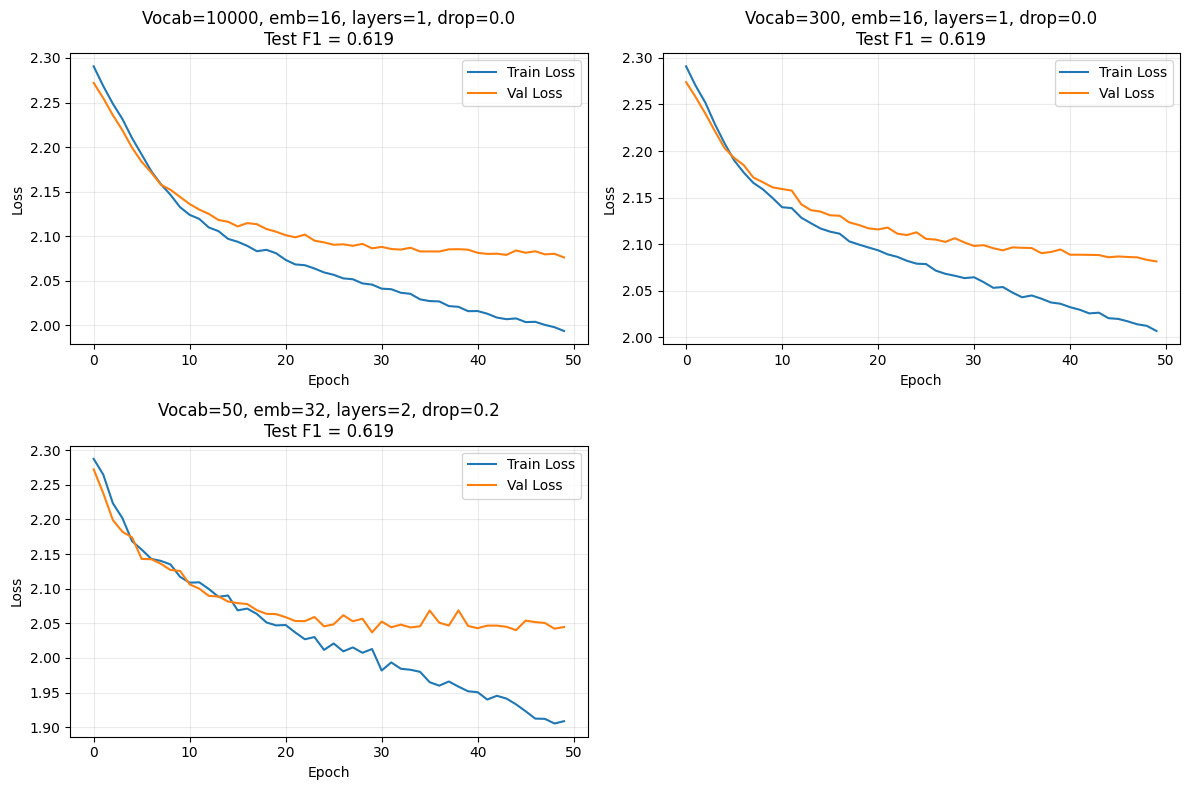

In [ ]:
def plot_all_scenarios(results_by_vocab):
    n = len(results_by_vocab)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), squeeze=False)
    for ax, (key, res) in zip(axes.ravel(), results_by_vocab.items()):
        train_losses = res.get("train_losses", [])
        val_losses   = res.get("val_losses", [])
        test_f1      = res.get("test_f1", float("nan"))
        ax.plot(train_losses, label="Train Loss")
        ax.plot(val_losses,   label="Val Loss")
        cfg = res.get("cfg", {})
        title = (f"Vocab={cfg.get('vocab_size', key)}, "f"emb={cfg.get('embed_dim', '?')}, "f"layers={cfg.get('n_hidden', '?')}, "f"drop={cfg.get('dropout', '?')}\n"f"Test F1 = {test_f1:.3f}")
        ax.set_title(title)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True, alpha=0.25)
        ax.legend(loc="best")

    for i in range(n, rows*cols):
        axes.ravel()[i].axis("off")
    plt.tight_layout()
    plt.show()

plot_all_scenarios(results_by_vocab)

**Question 25:**  
Create a bar plot comparing the test F1 scores for all scenarios.
- Use the scenario titles as x-axis labels.

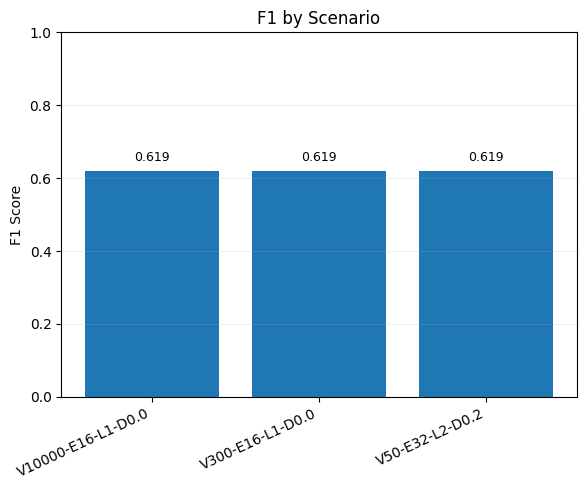

In [238]:
def plot_test_f1_bar(results_by_vocab):
    labels, scores = [], []

    for key, res in results_by_vocab.items():
        cfg = res.get("cfg", {})
        label = f"V{cfg.get('vocab_size', key)}-E{cfg.get('embed_dim','?')}-" \
                f"L{cfg.get('n_hidden','?')}-D{cfg.get('dropout','?')}"
        labels.append(label)
        scores.append(float(res.get("test_f1", float('nan'))))

    plt.figure(figsize=(max(6, 1.6*len(labels)), 5))
    bars = plt.bar(range(len(scores)), scores)
    plt.xticks(range(len(labels)), labels, rotation=25, ha='right')
    plt.ylim(0, 1.0)
    plt.ylabel("F1 Score")
    plt.title("F1 by Scenario")

    for b, s in zip(bars, scores):
        plt.text(b.get_x() + b.get_width()/2, s + 0.02, f"{s:.3f}",ha='center', va='bottom', fontsize=9)

    plt.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()

plot_test_f1_bar(results_by_vocab)